In [1]:
%matplotlib inline
import loompy
import logging
import pandas as pd
import numpy as np
import cytograph as cg
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import *
from sklearn.metrics.pairwise import cosine_distances
import numpy_groupies as npg
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sparse
import networkx as nx
import community
from sklearn.manifold import TSNE
import umap

2018-07-04 22:53:36,271 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


2018-07-01 16:44:51,368 DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/stelin/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


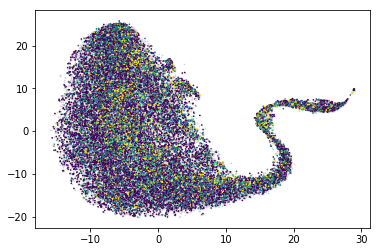

In [2]:
with loompy.connect("/Users/stelin/L1_OligoPons.loom") as ds:
    gene = "Sox10"
    plt.scatter(ds.ca._X,ds.ca._Y,s=10,lw=0,marker='.',c="lightgrey")
    cells = ds[ds.ra.Gene == gene, :][0] > 0
    color = ds[ds.ra.Gene == gene, :][0][cells]
    plt.scatter(ds.ca._X[cells],ds.ca._Y[cells],s=10,lw=0,vmax=np.percentile(color, 95),marker='.',c=color)


In [2]:
celltypes = ["OPC", "COP1", "COP2", "NFOL1", "NFOL2", "MFOL1", "MFOL2", "MOL1", "MOL2", "MOL3"]
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    genes = []
    for ct in celltypes:
        ix = np.where(ds.ca.ClusterName == ct)[0]
        enrichment = ds["enrichment"][:, ix][:,0]
        genes += list(np.argsort(-enrichment)[:100])
    genes = np.sort(ds.ra.Gene[np.unique(genes)])


In [3]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gene_ids = np.where(np.isin(ds.ra.Gene, genes))[0]
    genes = ds.ra.Gene[gene_ids]
    data = ds[gene_ids, :]

In [12]:
%%time
STEP = 16
d = data[:, ::STEP].transpose()
am = cg.AbsoluteManifold(radius=3, metric="variance_stabilized")
am.fit(d)

CPU times: user 6min 3s, sys: 1 s, total: 6min 4s
Wall time: 6min 5s


/Users/stelin/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


##### Using the "variance_stabilized" metric
```
64 -> 22 s
32 -> 1 min 22 s
16 -> 6 min 5 s
```

In [6]:
data_adj = (np.sqrt(data) + 0.8 * np.sqrt(data + 1)) / 1.8
sums = np.sum(data_adj, axis=0)
data_adj = data_adj / sums * np.median(sums)

/Users/stelin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [52]:
bt = BallTree(data_adj.T)
nn = bt.query(data_adj.T, k=10)


In [88]:
data_adj.shape

(542, 36609)

(array([0, 0, 0, ..., 0, 0, 0]), array([   25,    68,   522, ..., 35505, 35962, 36402]))


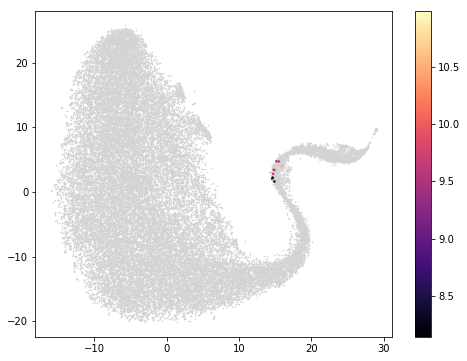

In [105]:
STEP = 1
N = d.shape[0]
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    print(np.where(ds[ds.ra.Gene == "Bmp4", :]>0))
    #print(ds.ca.keys())
    plt.figure(figsize=(8,6))
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    selected = nn[1][69,:]
    cax=plt.scatter(ds.ca._X[selected],ds.ca._Y[selected],s=25,vmin=np.percentile(nn[0][:,1], 1),vmax=np.percentile(nn[0][:,1], 99),cmap="magma",lw=0,marker='.',c=nn[0][:,1][selected])
    plt.colorbar(cax)

In [7]:
xy = umap.UMAP(n_neighbors=10, min_dist=0.1, metric=cg.stabilized_minkowski).fit_transform(data_adj.T)

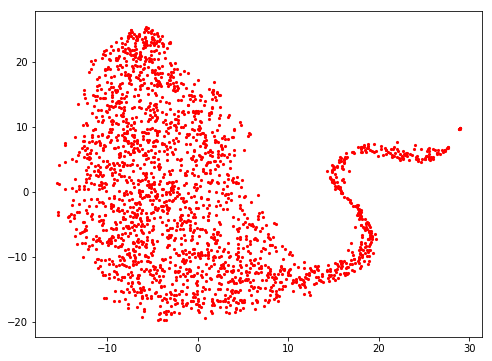

In [14]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.outliers()
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=40,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

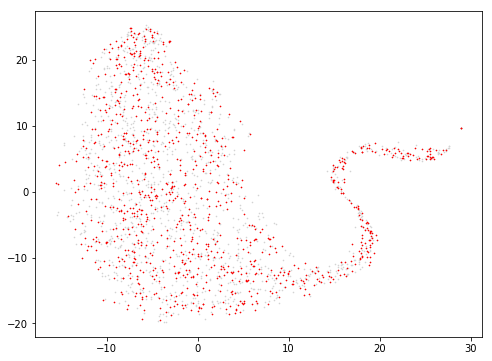

In [15]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.sample(N=1000, pseudocounts=10)
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

In [12]:
smoothened = am.smoothen(normalize=True)

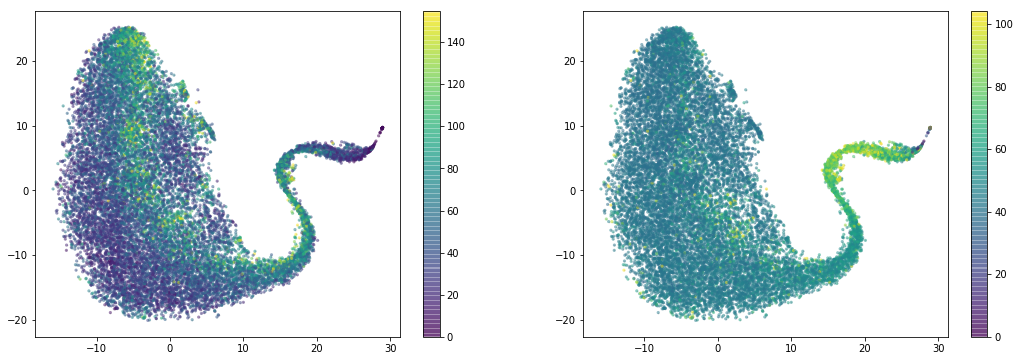

In [13]:
gene = "Mbp"
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(am.data[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=am.data[:,gix])
    plt.colorbar(cax)
    
    plt.subplot(1,2,2)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(smoothened[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix])
    plt.colorbar(cax)

In [58]:
xy = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      n_components=2,
                      metric=cg.poisson_distance_variance_stabilized
              ).fit_transform(data_adj.T)

AttributeError: module 'umap' has no attribute 'UMAP'

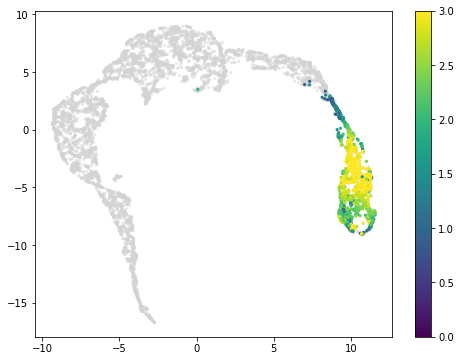

In [17]:
gene = "Itpr2"
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(8,6))
    plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,lw=0,marker='.',
                    c="lightgrey")

    cells = smoothened[:,gix][selected] > 0.8
    cax=plt.scatter(xy[:,0][cells],xy[:,1][cells],s=40,alpha=1,vmin=0,vmax=np.percentile(am.data[:,gix][selected],95),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix][selected][cells])
    plt.colorbar(cax)

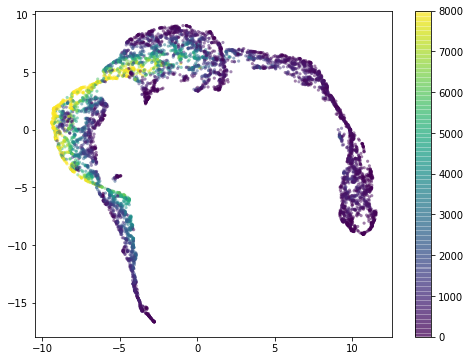

In [18]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=8000,cmap="viridis",lw=0,marker='.',c=am.n_neighbors[selected])
plt.colorbar(cax)

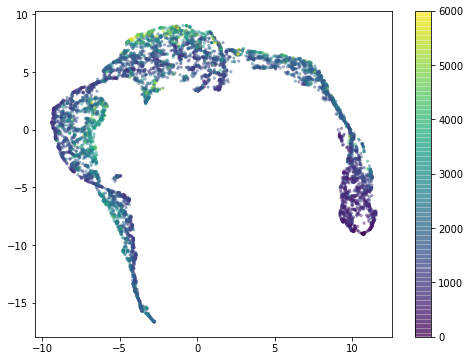

In [19]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=6000,cmap="viridis",lw=0,marker='.',c=am.data.sum(axis=1)[selected])
plt.colorbar(cax)